# Korelasi Fitur

Code untuk membuat figure penentuan fitur, dimana korelasi antara tiap fitur dihitung terhadap label. Hal ini dilakukan untuk mencari fitur dengan korelasi tertinggi sebagai fitur pada projek.


Fitur yang di uji:

- RMS: Root Mean Square
- ZCR: Zero Crossing Rate
- Spectral Centroid: Titik Pusat Spektrum (tidak disingkat, tapi nama lengkapnya sudah demikian)
- Log-mel Spectrogram: Logarithmic Mel-Frequency Spectrogram
- MFCC: Mel-Frequency Cepstral Coefficients


# Load


In [5]:
from typing import Tuple, List

import math
import numpy as np

import os
import joblib
import pickle

import librosa
import soundfile as sf
from scipy import signal, fftpack

import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.signal import resample_poly

from sklearn.preprocessing import StandardScaler

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

In [7]:
with open(MAIN_PATH + r"\Dataset\dataset_raw.pkl", "rb") as f:
    dataset = pickle.load(f)

In [21]:
with open(MAIN_PATH + r"\Result_Kombinasi_Model.pkl", "rb") as f:
    results = pickle.load(f)

# Results


Confusion Matrix


In [38]:
dict_models = {}

for model in results:
    if len(model["models"]) == 2:
        key = ', '.join(str(m) for m in model["models"])
    else:
        key = model["models"]
    # print(key, "\n", model["confusion_matrix"])
    dict_models[key] = model["confusion_matrix"]

In [39]:
dict_models

{'mamdani, mlp': array([[2092,   72,  444],
        [ 636, 2032,    0],
        [  48,  188, 1664]], dtype=int64),
 'mamdani, lgbm': array([[2012,  152,  444],
        [ 356, 2312,    0],
        [   4,  232, 1664]], dtype=int64),
 'lr, mlp': array([[2156,   72,  380],
        [ 636, 2032,    0],
        [  60,  296, 1544]], dtype=int64),
 'lr, lgbm': array([[2068,  160,  380],
        [ 356, 2312,    0],
        [  16,  340, 1544]], dtype=int64),
 'dt, mlp': array([[1948,   72,  588],
        [ 560, 2008,  100],
        [   4,   16, 1880]], dtype=int64),
 'dt, lgbm': array([[1892,  128,  588],
        [ 344, 2224,  100],
        [   0,   20, 1880]], dtype=int64),
 'lgbm': array([[2460,  104,   44],
        [ 292, 2328,   48],
        [ 124,   80, 1696]], dtype=int64),
 'mlp': array([[2504,   80,   24],
        [ 420, 2228,   20],
        [ 296,   56, 1548]], dtype=int64)}

In [45]:
def plot_confusion_matrix(cm, model_name, ax, class_names=None, cmap="Blues"):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=class_names if class_names else np.arange(len(cm)), 
                yticklabels=class_names if class_names else np.arange(len(cm)),
                ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix - {model_name}')

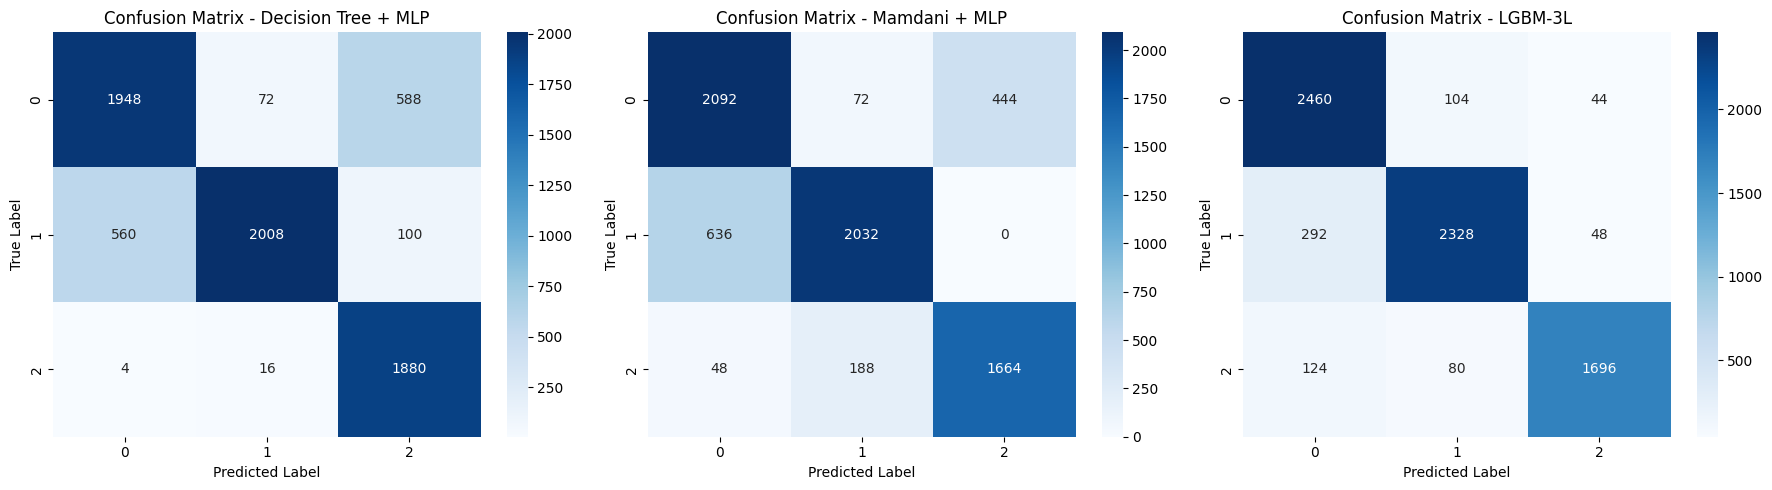

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(dict_models["dt, mlp"], "Decision Tree + MLP", axes[0])
plot_confusion_matrix(dict_models["mamdani, mlp"], "Mamdani + MLP", axes[1])
plot_confusion_matrix(dict_models["lgbm"], "LGBM-3L", axes[2])

plt.tight_layout()
plt.show()

# Functions


Pra-Pemrosesan


In [30]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

In [31]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

Ekstraksi Fitur


In [32]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_zcr(segment):
    return np.mean(librosa.feature.zero_crossing_rate(y=segment))

def get_sc(segment):
    return np.mean(librosa.feature.spectral_centroid(y=segment))

def get_lms(segment):
    return librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

# Ekstraksi Fitur


In [33]:
dataset

[{'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'Timestamp': [0.0, 1.0],
  'Label': 2,
  'Segment': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
          1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32)},
 {'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'Timestamp': [0.5, 1.5],
  'Label': 2,
  'Segment': array([ 0.00699983, -0.00232209, -0.00932763, ..., -0.04057191,
         -0.06078785, -0.05000736], dtype=float32)},
 {'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'Timestamp': [1.0, 2.0],
  'Label': 2,
  'Segment': array([ 0.00747406, -0.00234747, -0.01535155, ...,  0.01900513,
          0.05901422,  0.04412188], dtype=float32)},
 {'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-

In [34]:
dataset_fe = []

for data in dataset:
    segment = data["Segment"]

    features = {
        "Path": data["Path"],
        "Timestamp": data["Timestamp"],
        "Label": 1 if data["Label"] == 0 else data["Label"],
        "rms": np.mean(librosa.feature.rms(y=segment)),
        "zcr": np.mean(librosa.feature.zero_crossing_rate(y=segment)),
        "sc": np.mean(librosa.feature.spectral_centroid(y=segment)),
        "rolloff": np.mean(librosa.feature.spectral_rolloff(y=segment)),
        "bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=segment)),
        "mfcc_mean": np.mean(librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)),
        "mfcc_std": np.std(librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)),
        "lms_mean": np.mean(librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)),
        "lms_std": np.std(librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)),
        "contrast_mean": np.mean(librosa.feature.spectral_contrast(y=segment, sr=SAMPLE_RATE)),
        "contrast_std": np.std(librosa.feature.spectral_contrast(y=segment, sr=SAMPLE_RATE)),
        "tonnetz_mean": np.mean(librosa.feature.tonnetz(y=segment, sr=SAMPLE_RATE)),
        "tonnetz_std": np.std(librosa.feature.tonnetz(y=segment, sr=SAMPLE_RATE)),
        "chroma_mean": np.mean(librosa.feature.chroma_stft(y=segment, sr=SAMPLE_RATE)),
        "chroma_std": np.std(librosa.feature.chroma_stft(y=segment, sr=SAMPLE_RATE))
    }

    dataset_fe.append(features)

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [55]:
dataset_normalized = []

for data in dataset_fe:
    dataset_normalized.append({
        "Label": data["Label"],
        "rms": data["rms"],
        "zcr": data["zcr"],
        "sc": data["sc"],
        "mfcc_mean": data["mfcc_mean"],
        "mfcc_std": data["mfcc_std"],
        "lms_mean": data["lms_mean"],
        "lms_std": data["lms_std"],
    })

# Visualize


In [56]:
df = pd.DataFrame(dataset_normalized)

features = df.drop(columns=["Label"])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)

df_scaled["Label"] = df["Label"]

correlation_matrix = df_scaled.corr()

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


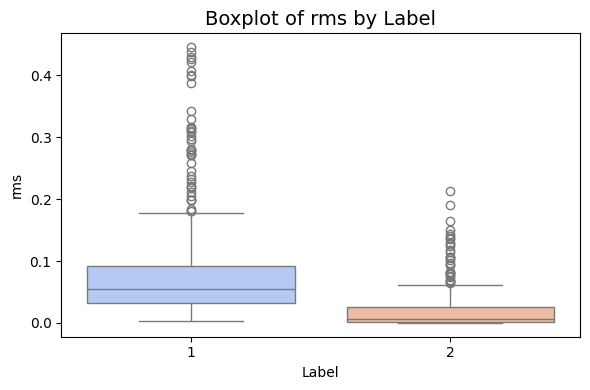

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


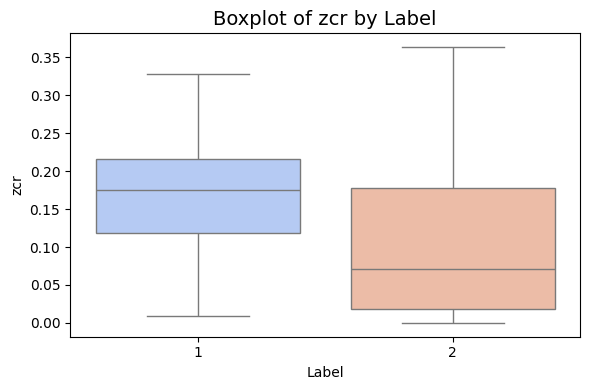

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


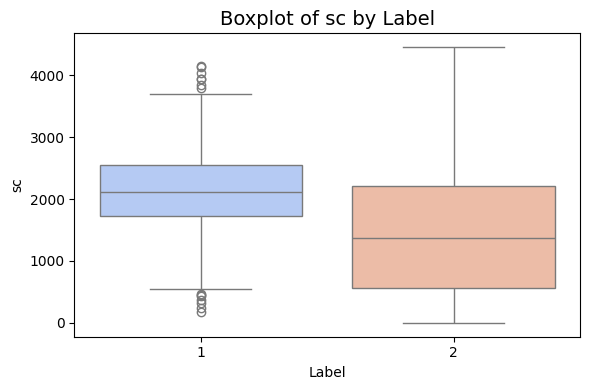

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


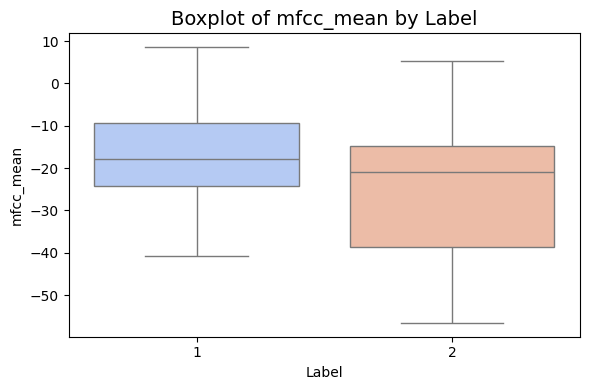

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


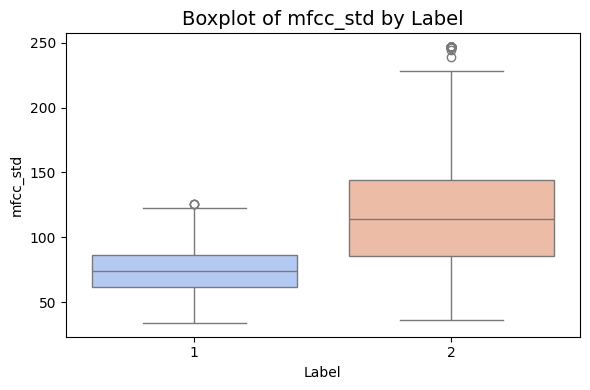

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


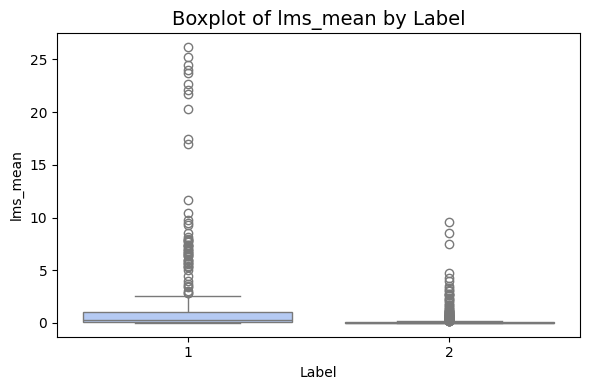

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


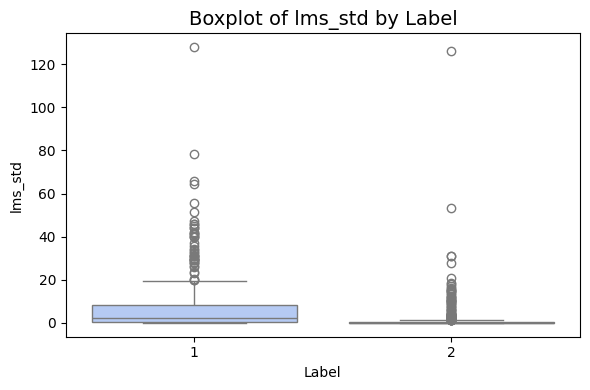

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(dataset_normalized)
features = df.columns.drop("Label")

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")
    plt.title(f"Boxplot of {feature} by Label", fontsize=14)
    plt.xlabel("Label")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


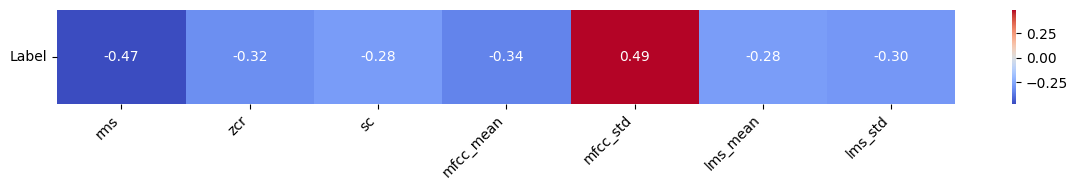

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(dataset_normalized)
correlation_matrix = df.corr(numeric_only=True)
label_corr = correlation_matrix.loc[["Label"]].drop(columns=["Label"])

plt.figure(figsize=(12, 2))
sns.heatmap(label_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Figure Visualize_RMS_ZCR_LMS


In [ ]:
def plot_audio_features(audio, sr=48000, segment_length_sec=1.0, overlap_sec=0.5, n_fft=2048, n_mels=128, n_mfcc=20):
    # Segment parameters
    segment_samples = int(segment_length_sec * sr)
    overlap_samples = int(overlap_sec * sr)
    step = segment_samples - overlap_samples
    total_samples = len(audio)

    # Time for full signal
    time = np.linspace(0, len(audio) / sr, len(audio))

    # Segment-wise RMS & ZCR
    rms_values = []
    zcr_values = []
    segment_times = []

    for start in range(0, total_samples - segment_samples + 1, step):
        end = start + segment_samples
        segment = audio[start:end]
        rms = np.sqrt(np.mean(segment**2))
        zcr = np.mean(librosa.zero_crossings(segment, pad=False))
        rms_values.append(rms)
        zcr_values.append(zcr)
        midpoint_time = (start + end) / 2 / sr
        segment_times.append(midpoint_time)

    # MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, n_mels=n_mels)

    # Plotting
    fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 3]})

    # Waveform
    ax[0].plot(time, audio, color='gray')
    ax[0].set_title('Raw Audio')
    ax[0].set_ylabel('Amplitude')

    # RMS
    ax[1].step(segment_times, rms_values, where='mid', color='teal')
    ax[1].set_title('Root Mean Square (RMS) per 1s Segment')
    ax[1].set_ylabel('RMS')

    # ZCR
    ax[2].step(segment_times, zcr_values, where='mid', color='darkgreen')
    ax[2].set_title('Zero-Crossing Rate (ZCR) per 1s Segment')
    ax[2].set_ylabel('ZCR')

    # MFCC
    img = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax[3], cmap='coolwarm')
    ax[3].set_title(f'MFCC (n_mfcc={n_mfcc})')
    fig.colorbar(img, ax=ax[3], format='%+2.0f dB')
    ax[3].set_ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()

In [ ]:
def prapemrosesan_cnth(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)

    return audio

In [ ]:
dir_contoh = MAIN_PATH+r"\Dataset\xeno-canto\884691.mp3"

contoh = prapemrosesan_cnth(dir_contoh)

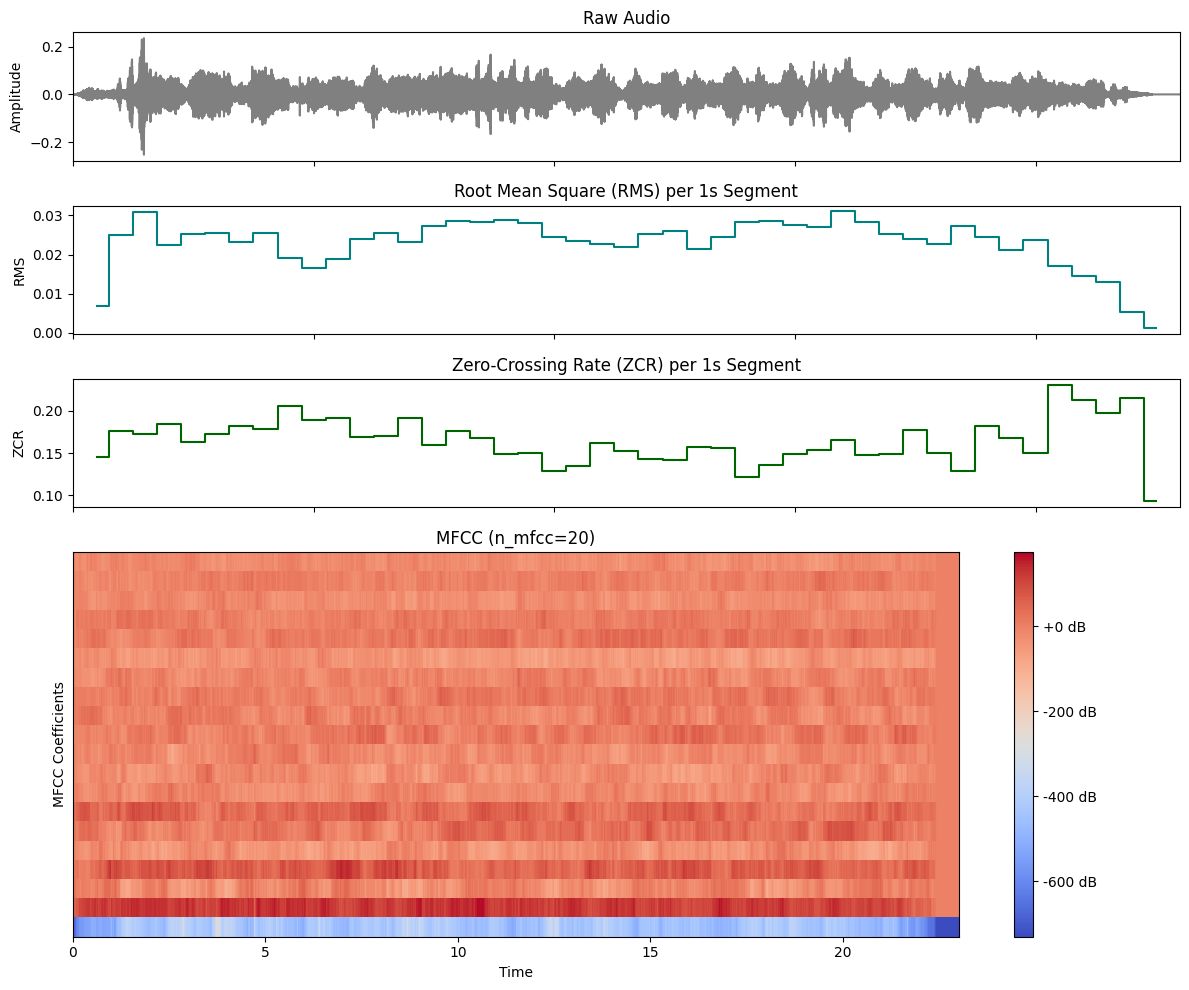

In [ ]:
plot_audio_features(contoh)

In [ ]:
min_rms = dataset_fe[0]
max_rms = dataset_fe[0]
min_zcr = dataset_fe[0]
max_zcr = dataset_fe[0]

for i in dataset_fe:
    rms = i[4]
    zcr = i[5]

    if rms > max_rms[4]:
        max_rms = i
    if rms < min_rms[4]:
        min_rms = i

    if zcr > max_zcr[5]:
        max_zcr = i
    if zcr < min_zcr[5]:
        min_zcr = i

print(f"Max RMS entry: {max_rms}")
print(f"Min RMS entry: {min_rms}")
print(f"Max ZCR entry: {max_zcr}")
print(f"Min ZCR entry: {min_zcr}")

In [ ]:
print(max_rms[4], min_rms[4])
print(max_zcr[5], min_zcr[5])

In [ ]:
for data in [max_rms, min_rms, max_zcr, min_zcr]:
    contoh_2 = data[7]
    time_2 = np.linspace(0, len(contoh_2) / SAMPLE_RATE, len(contoh_2))

    plt.plot(time_2, contoh_2, color='gray')
    plt.tight_layout()
    plt.show()